In [1]:
import numpy as np
from emnist import extract_training_samples, extract_test_samples
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Softmax, Activation, BatchNormalization, Flatten, Dropout, DepthwiseConv2D
from tensorflow.keras.layers import MaxPool2D, AvgPool2D, AveragePooling2D, GlobalAveragePooling2D, ZeroPadding2D, Input, Embedding, PReLU, Reshape
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import tensorflow as tf
import time
import os
import logging


from os import environ
environ['CUDA_VISIBLE_DEVICES'] = '0'

2023-12-02 18:53:43.554827: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-02 18:53:44.702731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# (x_train,y_train), (x_test,y_test) = mnist.load_data() 
x_train, y_train = extract_training_samples('digits')
x_test, y_test = extract_test_samples('digits')

In [3]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)/255
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)/255

y_train = to_categorical(y_train,num_classes=10) 
y_test = to_categorical(y_test,num_classes=10)

In [4]:
print("x_train shape : ", x_train.shape)
print("y_train shape : ", y_train.shape)

x_train shape :  (240000, 28, 28, 1)
y_train shape :  (240000, 10)


## Model 1 using MLP NN Only

In [5]:
#mnist_fc
def init_model2():
    model = Sequential()
    model.add(Flatten(input_shape = (28, 28, 1), name='flatten'))
    model.add(Dense(4, activation=tf.nn.relu))
    model.add(Dense(10, name="fc3"))
    model.add(Activation('softmax', name="sm"))
    return model

model2=init_model2()   
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 4)                 3140      
                                                                 
 fc3 (Dense)                 (None, 10)                50        
                                                                 
 sm (Activation)             (None, 10)                0         
                                                                 
Total params: 3190 (12.46 KB)
Trainable params: 3190 (12.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-12-02 18:54:10.121264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 18:54:10.215785: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Model 2 Using CNN + MLP NN

In [6]:
#mnist resnet
def init_model1(dim0):
    inputs = Input(shape=(28,28,1))
    x = Conv2D(dim0, (3,3), padding = 'same',strides = (2, 2), name='ftr0')(inputs)
    x = BatchNormalization(name="bn0")(x)
    x = Activation('relu', name="relu0")(x)
    
    x = Conv2D(dim0*2, (3,3), padding = 'same',strides = (2, 2), name='ftr1')(x)
    x = BatchNormalization(name="bn1")(x)
    x = Activation('relu', name="relu1")(x)
    res = x
    
    x = Conv2D(dim0*2, (3,3), padding = 'same', name='ftr2')(x)
    x = BatchNormalization(name="bn2")(x)
    
    x = res + x
    
    x = Conv2D(dim0*4, (3,3), padding = 'valid',strides = (2, 2), name='ftr3')(x)
    x = Flatten(name='reshape')(x)
    x = Dense(10, name="fc1")(x)
    
    x = Activation('softmax', name="sm")(x)
    model = Model(inputs = inputs, outputs=x)
    
    return model

DIM0 = 12
model1=init_model1(DIM0)   
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 ftr0 (Conv2D)               (None, 14, 14, 12)           120       ['input_1[0][0]']             
                                                                                                  
 bn0 (BatchNormalization)    (None, 14, 14, 12)           48        ['ftr0[0][0]']                
                                                                                                  
 relu0 (Activation)          (None, 14, 14, 12)           0         ['bn0[0][0]']                 
                                                                                              

## Visualizing Layer on Model 1

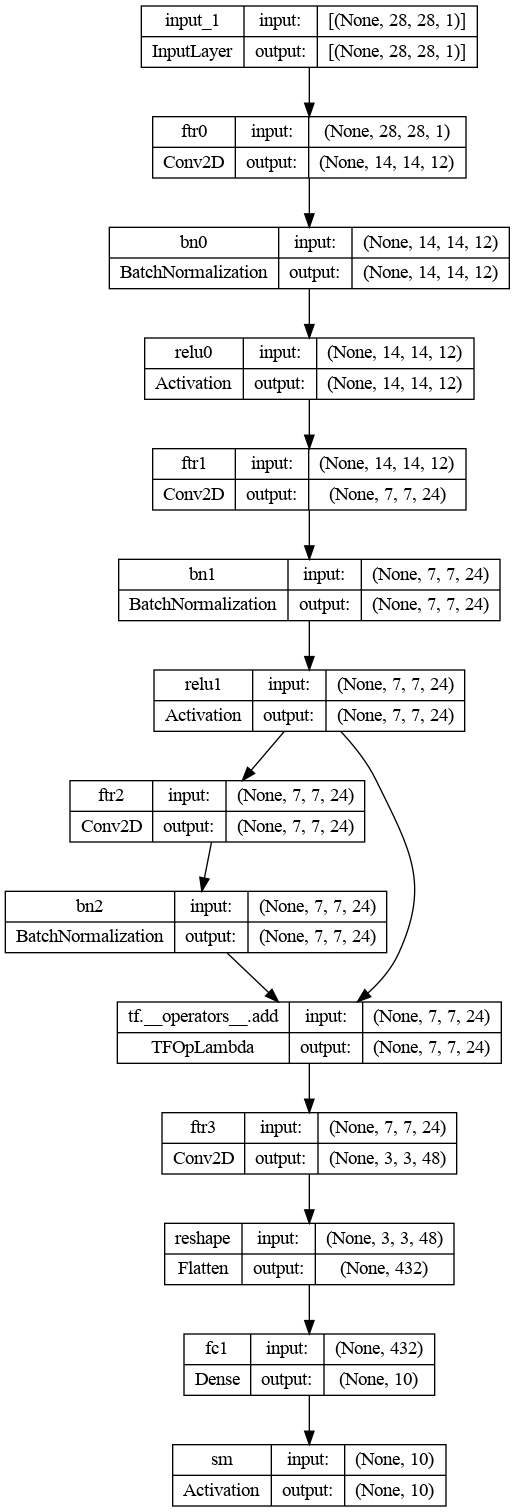

In [7]:
# from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


## Visualizing Layer on Model 2

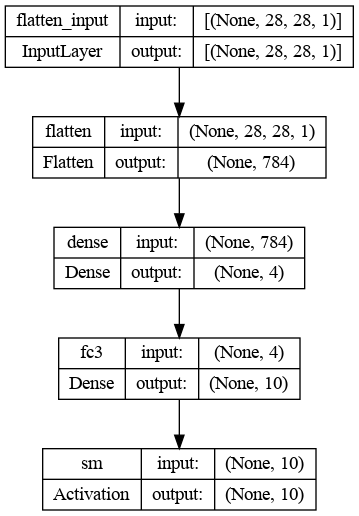

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
EPOCHS = 10
model1.compile(optimizer='adam', loss = "categorical_crossentropy", metrics = ["categorical_accuracy"]) 
H1 = model1.fit(x_train, y_train, batch_size=64, epochs= EPOCHS,  verbose= 1, validation_data = (x_test, y_test), shuffle=True) 

Epoch 1/10
3750/3750 [==============================] - 24s 6ms/step - loss: 0.0885 - categorical_accuracy: 0.9739 - val_loss: 0.0558 - val_categorical_accuracy: 0.9840
Epoch 2/10
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0486 - categorical_accuracy: 0.9860 - val_loss: 0.0488 - val_categorical_accuracy: 0.9862
Epoch 3/10
3750/3750 [==============================] - 19s 5ms/step - loss: 0.0401 - categorical_accuracy: 0.9881 - val_loss: 0.0399 - val_categorical_accuracy: 0.9880
Epoch 4/10
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0356 - categorical_accuracy: 0.9894 - val_loss: 0.0384 - val_categorical_accuracy: 0.9887
Epoch 5/10
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0323 - categorical_accuracy: 0.9906 - val_loss: 0.0348 - val_categorical_accuracy: 0.9898
Epoch 6/10
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0301 - categorical_accuracy: 0.9912 - val_loss: 0.0358 - val_categorical_acc

In [10]:
EPOCHS = 10
model2.compile(optimizer='adam', loss = "categorical_crossentropy", metrics = ["categorical_accuracy"]) 
H2 = model2.fit(x_train, y_train, batch_size=64, epochs= EPOCHS,  verbose= 1, validation_data = (x_test, y_test), shuffle=True) 

Epoch 1/10
3750/3750 [==============================] - 5s 943us/step - loss: 0.6825 - categorical_accuracy: 0.8042 - val_loss: 0.4747 - val_categorical_accuracy: 0.8666
Epoch 2/10
3750/3750 [==============================] - 3s 803us/step - loss: 0.4508 - categorical_accuracy: 0.8775 - val_loss: 0.4320 - val_categorical_accuracy: 0.8782
Epoch 3/10
3750/3750 [==============================] - 3s 809us/step - loss: 0.4235 - categorical_accuracy: 0.8833 - val_loss: 0.4141 - val_categorical_accuracy: 0.8819
Epoch 4/10
3750/3750 [==============================] - 3s 783us/step - loss: 0.4126 - categorical_accuracy: 0.8857 - val_loss: 0.4084 - val_categorical_accuracy: 0.8831
Epoch 5/10
3750/3750 [==============================] - 3s 798us/step - loss: 0.4058 - categorical_accuracy: 0.8874 - val_loss: 0.4062 - val_categorical_accuracy: 0.8843
Epoch 6/10
3750/3750 [==============================] - 3s 811us/step - loss: 0.4021 - categorical_accuracy: 0.8880 - val_loss: 0.3982 - val_categoric

## Saving Model 1 to h5 file

In [12]:
h5_file1 = "mnist_model1.h5"
model1.save(h5_file1)

/home/rizqi/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Saving Model 2 to h5 file

In [13]:
h5_file2 = "mnist_model2.h5"
model2.save(h5_file2)

## Testing NN

In [14]:
data = x_test[1]
for y in range(28):
    for x in range(28):
        print("%3d,"%(int(data[y,x,0]*255)), end="")
    print("")

  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 22,114,140,184,169, 83,  5,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8, 95,219,253,250,227,252,248, 37,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 20,122,232,250,209,139, 64,189,247, 37,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0, 18,175,246,207, 95,  9,  0,  1,141,230, 21,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0, 40,247,221, 47,  7,  0,  0, 20,220,237, 25,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0, 20,207,220, 79,  0,  0,  0,  0, 37,250,252, 69,  1,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0, 37,231, 67,  3,  0,  0,  0,  0, 51,251,250, 39,  0,  0,  0,  0,

In [15]:
result = model1.predict(x_test[1:2])[0]
result

1/1 [==============================] - 0s 158ms/step


array([4.7441766e-09, 1.1247010e-07, 4.3102809e-05, 3.4069825e-07,
       7.7993782e-06, 4.0619644e-10, 1.9625591e-11, 1.0826697e-03,
       1.2919385e-02, 9.8594660e-01], dtype=float32)

In [16]:
result = model2.predict(x_test[1:2])[0]
result

1/1 [==============================] - 0s 47ms/step


array([5.5543653e-05, 1.5268950e-02, 2.6355132e-05, 1.2038330e-02,
       6.5911622e-03, 2.8868867e-03, 3.1061012e-07, 1.0309162e-01,
       4.9124554e-02, 8.1091630e-01], dtype=float32)

In [17]:
def save_tflite_model(tflite_model, save_dir, model_name):
  """save the converted tflite model
  Args:
      tflite_model (binary): the converted model in serialized format.
      save_dir (str): the save directory
      model_name (str): model name to be saved
  """
  if not os.path.exists(save_dir):
    os.makedirs(save_dir)
  save_path = os.path.join(save_dir, model_name)
  with open(save_path, "wb") as f:
    f.write(tflite_model)
  logging.info("Tflite model saved to %s", save_dir)

In [18]:
#convert and save the model1 to .tflite
converter1 = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model1 = converter1.convert()
save_tflite_model(tflite_model1,
                  "./",
                  model_name="mnist_model1.tflite")

#convert and save the model2 to .tflite
converter2 = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model2 = converter2.convert()
save_tflite_model(tflite_model2,
                  "./",
                  model_name="mnist_model2.tflite")


INFO:tensorflow:Assets written to: /tmp/tmpm0g9styc/assets


INFO:tensorflow:Assets written to: /tmp/tmpm0g9styc/assets
2023-12-02 19:03:08.552574: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-12-02 19:03:08.552602: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-12-02 19:03:08.563980: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm0g9styc
2023-12-02 19:03:08.565430: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-12-02 19:03:08.565441: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpm0g9styc
2023-12-02 19:03:08.576957: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-12-02 19:03:08.578621: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-12-02 19:03:08.639381: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

INFO:tensorflow:Assets written to: /tmp/tmp4vlx122c/assets


INFO:tensorflow:Assets written to: /tmp/tmp4vlx122c/assets
2023-12-02 19:03:09.280653: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-12-02 19:03:09.280674: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-12-02 19:03:09.280792: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4vlx122c
2023-12-02 19:03:09.281301: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-12-02 19:03:09.281310: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp4vlx122c
2023-12-02 19:03:09.282949: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-12-02 19:03:09.302872: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp4vlx122c
2023-12-02 19:03:09.308862: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

## Generating model header file for use on C ESP-IDF 

In [19]:
# !xxd -i mnist.tflite > model_data.cc
import binascii

def convert_to_c_array(bytes) -> str:
  hexstr = binascii.hexlify(bytes).decode("UTF-8")
  hexstr = hexstr.upper()
  array = ["0x" + hexstr[i:i + 2] for i in range(0, len(hexstr), 2)]
  array = [array[i:i+10] for i in range(0, len(array), 10)]
  return ",\n  ".join([", ".join(e) for e in array])

# creating for model1
tflite_binary = open("mnist_model1.tflite", 'rb').read()
ascii_bytes = convert_to_c_array(tflite_binary)
c_file = "const unsigned char mnist_tflite[] = {\n  " + ascii_bytes + "\n};\nunsigned int mnist_tflite_len = " + str(len(tflite_binary)) + ";"
# print(c_file)
open("./main/model_data.h", "w").write(c_file)

# creating for model2
tflite_binary = open("mnist_model2.tflite", 'rb').read()
ascii_bytes = convert_to_c_array(tflite_binary)
c_file = "const unsigned char mnist_tflite[] = {\n  " + ascii_bytes + "\n};\nunsigned int mnist_tflite_len = " + str(len(tflite_binary)) + ";"
# print(c_file)
open("./main/model_data2.h", "w").write(c_file)

91393